<a href="https://colab.research.google.com/github/dr-mushtaq/AIBauchi-Computer-Vision-Bootcamp/blob/main/Model_Training_Mushtaq_V2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Table of Content**</p>



1.   Import Library
2.   Import Dataset
3.   Data Preprocessing
4.   Neural Network
4.   LSTM
4.   BERT
4.   T5 & Flan-T5 (Google)




#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**1-Import library**</p>

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**2-Import Dataset**</p>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('/content/gdrive/MyDrive/Research /Research Projects/Chatbot System in Education /Dataset/intents.json').read()
intents = json.loads(data_file)


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**3-Data Preprocessing**</p>

##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**3.1- Orginal Data Preprocessing**</p>

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [ ]:
 import nltk
 nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# lemmaztize and lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)



235 documents
93 classes [' ADMISSION OF FOREIGN/DUAL NATIONAL', ' Additional Specialization Certificate', ' Admission Status', ' Alumni Association ', ' Citizen complaint portal ', ' Club and Societies ', ' Courses Catalogue', ' Degree/Transcript Verification ', ' Digiskills ', ' Disabled Student Fee structure(Local)', ' Disabled Student Fee structure(Overseas)', ' Exam Superintendent Registration ', ' FACULTY OF SCIENCE & TECHNOLOGY Programs', ' Faculty of Arts Programs', ' Faculty of Education Programs', ' Faculty of Management Programs', ' Grading Scheme', ' How to Apply Online', ' Life at VU', ' New Registration', ' ORIC ', ' PROFESSIONAL COURSES DEVELOPMENT', ' PROTECTION AGAINST HARASSMENT  ', ' Prospectus', ' RIGHT OF ACCESS TO INFORMATION ', ' Recent Advertisements of VU', ' Schedule of other Charges', ' Short Certificate Course', ' Student Startup', ' Study Scheme', ' Suitability of  VU', ' Tender', ' Vendor Registration ', ' Zero Semester', 'Academic Calendar', 'Acceptable a

In [ ]:
pickle.dump(words,open('texts.pkl','wb'))
pickle.dump(classes,open('labels.pkl','wb'))

**Create our training data**

In [ ]:
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)

# Padding to ensure consistent shape for bag-of-words representations
max_len = max(len(sample[0]) for sample in training)  # Find the maximum length
padded_training = []
for sample in training:
    bag, output_row = sample
    # Check if padding is actually necessary
    if len(bag) < max_len:
        padded_bag = bag + [0] * (max_len - len(bag))  # Pad with zeros if needed
    else:
        padded_bag = bag  # No padding needed
    padded_training.append([padded_bag, output_row])

training = np.array(padded_training, dtype=object) # Convert the padded list to NumPy array, allow object dtype


# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")


Training data created


##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**3.2- Improve Version  Data Preprocessing**</p>

**Suggested Optimization**

1. **Padding is unnecessary for bag-of-words**

Bag-of-words (BoW) representations are already of fixed length because the word list (words) defines the dimensionality. The for w in words loop ensures each vector has the same length. Thus, the explicit padding step is redundant.

2. **Potential Issue with np.array Conversion**

np.array(training, dtype=object) is used, but NumPy arrays are better suited for numerical data. Consider using np.array(training, dtype=np.float32) if all values are numerical.

3. **Shuffling Before NumPy Conversion**

You correctly shuffle the data before converting it to a NumPy array, which is good practice to ensure randomness in training.

In [ ]:
import random
import numpy as np

# Create our training data
training = []

# Create an empty array for output (one-hot encoded)
output_empty = [0] * len(classes)

# Training set: bag of words for each sentence
for doc in documents:
    # Initialize our bag of words
    bag = [1 if w in [lemmatizer.lemmatize(word.lower()) for word in doc[0]] else 0 for w in words]

    # Output is '1' for current tag, '0' for others
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

# Shuffle and convert to NumPy array
random.shuffle(training)
training = np.array(training, dtype=object)

# Split features and labels
train_x = list(training[:, 0])  # Input patterns
train_y = list(training[:, 1])  # Corresponding intents

print("Training data created")


Training data created


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**4- Data Spliting**</p>

**Data Spliting training  Test**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import random

# Shuffle the dataset before splitting
random.shuffle(training)

# Convert to NumPy array for easier slicing
training = np.array(padded_training, dtype=object)  # Ensure object dtype for mixed types

# Extract features and labels
X = list(training[:, 0])  # Patterns (bag of words)
Y = list(training[:, 1])  # Corresponding intents (one-hot vectors)

# Split into training and testing sets (80% train, 20% test)
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_x)}, Testing samples: {len(test_x)}")
print("Training and testing data successfully created!")


Training samples: 188, Testing samples: 47
Training and testing data successfully created!


**Data Spliting -Train-Dev-Test**

In [ ]:
from sklearn.model_selection import train_test_split

# First, split data into train + temp (which will be split further into dev and test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=1)

# Now, split temp into dev and test (50% each from temp)
dev_texts, test_texts, dev_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, shuffle=True, random_state=1)

# Print dataset sizes
print("Train:", len(train_texts))
print("Dev:", len(dev_texts))
print("Test:", len(test_texts))


Train: 188
Dev: 23
Test: 24


In [ ]:
!pip install datasets


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5- Model training and Evaulation**</p>

**Metrics for Evaluation:**

**Metric and Purpose**

1- F1 Score	Measures chatbot response accuracy

2- BLEU Score	Evaluates response fluency

3- Perplexity	Measures how well the model predicts next words
Response Time	Checks chatbot speed


##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.1-Neural Netowrk**</p>


###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.1.1  Orginal Model Training**</p>

In [ ]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True) # Changed 'lr' to 'learning_rate'
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)

###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.1.2 Training and Testing**</p>

**Training and Testing V1**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming 'documents' contains the original text data as a list of tuples (words, intent)
train_texts_str = [' '.join(doc[0]) for doc in documents]  # Extract text from documents list
# split into train, dev, and test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(train_texts_str, [doc[1] for doc in documents], test_size=0.2, shuffle=True, random_state=1)
dev_texts, test_texts, dev_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, shuffle=True, random_state=1)

# Step 1: Convert Text Data into Numerical Format using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust features as needed
X_train_tfidf = vectorizer.fit_transform(train_texts).toarray()
X_dev_tfidf = vectorizer.transform(dev_texts).toarray()
X_test_tfidf = vectorizer.transform(test_texts).toarray()

# Step 2: Convert Labels to Categorical Format
# Fit the label encoder to all unique labels to avoid the error
all_labels = list(set(train_labels + dev_labels + test_labels))  # Combine all labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)  # Fit before transforming

y_train_encoded = label_encoder.transform(train_labels)
y_dev_encoded = label_encoder.transform(dev_labels)
y_test_encoded = label_encoder.transform(test_labels)

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train_encoded, num_classes=len(all_labels))  # Ensure consistent num_classes
y_dev_categorical = to_categorical(y_dev_encoded, num_classes=len(all_labels))
y_test_categorical = to_categorical(y_test_encoded, num_classes=len(all_labels))

# Step 3: Create Model - 3 Layers (128 → 64 → Output)
model = Sequential()
model.add(Dense(128, input_shape=(X_train_tfidf.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(all_labels), activation='softmax'))  # Use len(all_labels) for output layer

# Step 4: Compile Model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Step 5: Train Model with Validation
hist = model.fit(
    np.array(X_train_tfidf), np.array(y_train_categorical),
    epochs=200, batch_size=5, verbose=1,
    validation_data=(np.array(X_dev_tfidf), np.array(y_dev_categorical))
)

# Step 6: Evaluate on Test Set
test_loss, test_acc = model.evaluate(np.array(X_test_tfidf), np.array(y_test_categorical), verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

**Training and Testing Version 2**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming 'documents' contains text data as (word_list, intent)
train_texts_str = [' '.join(doc[0]) for doc in documents]
labels = [doc[1] for doc in documents]

# Split into train, dev, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    train_texts_str, labels, test_size=0.2, shuffle=True, random_state=1)
dev_texts, test_texts, dev_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, shuffle=True, random_state=1)

# Convert text to numerical format using TF-IDF
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(train_texts).toarray()
X_dev_tfidf = vectorizer.transform(dev_texts).toarray()
X_test_tfidf = vectorizer.transform(test_texts).toarray()

# Normalize TF-IDF features
scaler = StandardScaler()
X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_dev_tfidf = scaler.transform(X_dev_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)

# Encode labels
all_labels = list(set(labels))
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

y_train_encoded = label_encoder.transform(train_labels)
y_dev_encoded = label_encoder.transform(dev_labels)
y_test_encoded = label_encoder.transform(test_labels)

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train_encoded, num_classes=len(all_labels))
y_dev_categorical = to_categorical(y_dev_encoded, num_classes=len(all_labels))
y_test_categorical = to_categorical(y_test_encoded, num_classes=len(all_labels))

# Build neural network model
model = Sequential([
    Dense(256, input_shape=(X_train_tfidf.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(all_labels), activation='softmax')
])

# Compile model using Adam optimizer
adam = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train model
hist = model.fit(
    X_train_tfidf, y_train_categorical,
    epochs=300, batch_size=64, verbose=1,
    validation_data=(X_dev_tfidf, y_dev_categorical),
    callbacks=[early_stopping]
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_tfidf, y_test_categorical, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.0046 - loss: 5.0025 - val_accuracy: 0.0000e+00 - val_loss: 4.6595
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.0119 - loss: 5.0956 - val_accuracy: 0.0000e+00 - val_loss: 4.6265
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0296 - loss: 4.6502 - val_accuracy: 0.0000e+00 - val_loss: 4.5892
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0440 - loss: 4.5939 - val_accuracy: 0.0000e+00 - val_loss: 4.5511
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0342 - loss: 4.4059 - val_accuracy: 0.0000e+00 - val_loss: 4.5149
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0756 - loss: 4.2349 - val_accuracy: 0.0000e+00 - val_loss: 4.4788
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0632 - loss: 4.1417 - val_accuracy: 0.0000e+00 - val_loss: 4.4409
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1309 - loss: 3.9299 - val_accuracy: 0.0

**Observations & Suggestions**

1. **Dropout Rate**

You are using 0.5 dropout after both hidden layers, which is quite aggressive. This might slow down training or cause underfitting. Try 0.3 instead of 0.5.

2. **Optimizer Choice**

SGD with Nesterov momentum works well, but Adam optimizer (optimizer='adam') is often better for deep learning models in NLP tasks.

If you want to stick with SGD, consider learning rate decay scheduling to improve training convergence.

3. **Epochs & Batch Size Tuning**

epochs=200 might be excessive unless you have a large dataset. Try 100 epochs first, then increase if needed.

batch_size=5 is quite small. Try 16 or 32 for better efficiency.

4. **Convert Lists to NumPy Arrays Before Training**

Ensure train_x and train_y are explicitly converted to NumPy arrays before feeding them into model.fit().



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np

# Create the model
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.3))  # Reduced dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Reduced dropout
model.add(Dense(len(train_y[0]), activation='softmax'))

# Choose optimizer (SGD with decay or Adam)
optimizer = Adam(learning_rate=0.001)  # Adam usually performs better
# optimizer = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)  # Optional

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Convert to NumPy arrays
train_x = np.array(train_x)
train_y = np.array(train_y)

# Train the model
hist = model.fit(train_x, train_y, epochs=100, batch_size=16, verbose=1)

# Save the trained model
model.save("chatbot_model.h5")

print("Model training complete and saved as chatbot_model.h5")

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.0168 - loss: 4.5451
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0250 - loss: 4.4858    
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0350 - loss: 4.4431     
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0869 - loss: 4.3896 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1504 - loss: 4.3196 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1643 - loss: 4.2314 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1344 - loss: 4.1026 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1796 - loss: 3.9737 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1873 - loss: 3.8201 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2587 - loss: 3.5627 
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2342 - loss: 3.5088 
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3

Model training complete and saved as chatbot_model.h5


###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.1.3  Orginal Model Saving**</p>

In [ ]:
model.save('chat_model.keras', hist) # Changed 'chat_model' to 'chat_model.keras' to include the .keras extension
print("model created")

model created



##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.2-Random Forest**</p>

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'documents' contains text data as (word_list, intent)
train_texts_str = [' '.join(doc[0]) for doc in documents]
labels = [doc[1] for doc in documents]

# Split into train, dev, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    train_texts_str, labels, test_size=0.2, shuffle=True, random_state=1)
dev_texts, test_texts, dev_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, shuffle=True, random_state=1)

# Convert text to numerical format using TF-IDF
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(train_texts).toarray()
X_dev_tfidf = vectorizer.transform(dev_texts).toarray()
X_test_tfidf = vectorizer.transform(test_texts).toarray()

# Normalize TF-IDF features
scaler = StandardScaler()
X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_dev_tfidf = scaler.transform(X_dev_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)

# Encode labels - Fit only on training labels to prevent data leakage
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)  # Fit only on training labels

y_train_encoded = label_encoder.transform(train_labels)
y_dev_encoded = label_encoder.transform(dev_labels)
y_test_encoded = label_encoder.transform(test_labels)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=1, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train_encoded)

# Evaluate on dev set
y_dev_pred = rf_model.predict(X_dev_tfidf)
dev_acc = accuracy_score(y_dev_encoded, y_dev_pred)
print(f"Validation Accuracy: {dev_acc:.4f}")

# Get unique labels from test set for classification report
unique_test_labels = list(label_encoder.classes_)  # Get the fitted labels

# Evaluate on test set
y_test_pred = rf_model.predict(X_test_tfidf)
test_acc = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")
print("Classification Report:")
# Use unique_test_labels as target_names
print(classification_report(y_test_encoded, y_test_pred, target_names=unique_test_labels))

ValueError: y contains previously unseen labels: np.str_('institution')

##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.3- LSTM**</p>

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Flatten,Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional

###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.3.1-Model Architecture 1**</p>


Stacked LSTM (multi-layer LSTM) with Batch Normalization

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay # Import ExponentialDecay
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Flatten,Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional

#Create the LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(len(train_x[0]),1), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(32,return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(16,return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(len(train_y[0]),activation="softmax"))
model.summary()
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
lr_schedule = ExponentialDecay( # Now you can use ExponentialDecay
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
#adam = Adam(learning_rate=lr_schedule)
sgd = SGD(learning_rate=0.01 ,momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=128, verbose=1)

###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.3.2 - Model Architecture 2**</p>

Deeper Stacked LSTM architecture

In [ ]:
#Create the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(len(train_x[0]),1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(32,return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(16,return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(len(train_y[0]),activation="softmax"))
model.summary()
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
#adam = Adam(learning_rate=lr_schedule)
sgd = SGD(learning_rate=0.001 ,momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=100, batch_size=128, verbose=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 290, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 290, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 290, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 290, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 290, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 290, 32)             │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 290, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 290, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 93)                  │           1,581 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,549 (521.68 KB)

 Trainable params: 133,325 (520.80 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.0274 - loss: 4.6192
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0248 - loss: 4.6626
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0111 - loss: 4.6952
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0083 - loss: 4.6303 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0109 - loss: 4.6840
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0028 - loss: 4.6807    
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0054 - loss: 4.6634
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0109 - loss: 4.6642
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0000e+00 - loss: 4.7125
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0083 - loss: 4.7032
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0192 - loss: 4.5723
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0

###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.3.3 - Model Architecture 3**</p>


Bidirectional LSTMs

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=64,input_shape=(len(train_x[0]),1),return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=32,return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=16,return_sequences=False)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(len(train_y[0]),activation="softmax"))

# Build the model
model.build(input_shape=(None, len(train_x[0]), 1))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 290, 128)            │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 290, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 290, 64)             │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 290, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 290, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 93)                  │           3,069 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,829 (346.99 KB)

 Trainable params: 88,637 (346.24 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
sgd = SGD(learning_rate=0.001 ,momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=100, batch_size=128, verbose=1)

Epoch 1/100
932/932 [==============================] - 89s 80ms/step - loss: 4.5237 - accuracy: 0.0520
Epoch 2/100
932/932 [==============================] - 73s 79ms/step - loss: 3.7492 - accuracy: 0.1474
Epoch 3/100
932/932 [==============================] - 74s 79ms/step - loss: 3.2352 - accuracy: 0.2316
Epoch 4/100
932/932 [==============================] - 73s 79ms/step - loss: 2.7851 - accuracy: 0.3036
Epoch 5/100
932/932 [==============================] - 73s 79ms/step - loss: 2.4090 - accuracy: 0.3725
Epoch 6/100
932/932 [==============================] - 73s 78ms/step - loss: 2.0772 - accuracy: 0.4478
Epoch 7/100
932/932 [==============================] - 74s 79ms/step - loss: 1.7939 - accuracy: 0.5148
Epoch 8/100
932/932 [==============================] - 74s 80ms/step - loss: 1.5713 - accuracy: 0.5678
Epoch 9/100
932/932 [==============================] - 74s 80ms/step - loss: 1.3666 - accuracy: 0.6160
Epoch 10/100
932/932 [==============================] - 74s 80ms/step - l

In [ ]:
model.save( path_to_save_model+'chat_model_3', hist)
print("model created and saved")

model created and saved


###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.3.4 - Model Architecture 4**</p>


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128,input_shape=(len(train_x[0]),1),return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=64,return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=32,return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=16,return_sequences=False)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(len(train_y[0]),activation="softmax"))

# Build the model
model.build(input_shape=(None, len(train_x[0]), 1))

model.summary()

sgd = SGD(learning_rate=0.001 ,momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=100, batch_size=128, verbose=1)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 290, 256)            │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 290, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 290, 128)            │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 290, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 290, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 290, 64)             │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 290, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 290, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 93)                  │           3,069 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,021 (1.35 MB)

 Trainable params: 352,573 (1.34 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.0166 - loss: 4.8186
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.0192 - loss: 4.6949
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.0137 - loss: 4.7191
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.0083 - loss: 4.6688
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.0163 - loss: 4.7570
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.0083 - loss: 4.7697
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.0057 - loss: 4.8055
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.0000e+00 - loss: 4.7959
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.0083 - loss: 4.7751
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.0083 - loss: 4.8480
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.0166 - loss: 4.7589
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accur

In [ ]:
model.save( path_to_save_model+'chat_model_4', hist)
print("model created and saved")

model created and saved


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128,input_shape=(len(train_x[0]),1),return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=64,return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=32,return_sequences=True)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=16,return_sequences=False)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(len(train_y[0]),activation="softmax"))

# Build the model
model.build(input_shape=(None, len(train_x[0]), 1))

model.summary()

sgd = SGD(learning_rate=0.001 ,momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=100, batch_size=128, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 391, 256)          133120    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 391, 256)          1024      
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 391, 128)          164352    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 391, 128)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 391, 64)           41216     
 onal)                                                  

In [ ]:
model.save( path_to_save_model+'chat_model_5', hist)
print("model created and saved")


##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.4-BERT**</p>

**AP Code:f2c9503483a3657c26b3a21194b5d12d492a3053**

###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.4.1-Check imbplance Probme**</p>

In [ ]:
!pip install datasets

Label distribution: Counter({'help': 7, 'complaint': 6, 'greeting': 5, 'create account': 5, 'student status updation': 5, 'thanks': 4, 'Credit': 4, 'Campus changed': 4, 'student status (Overseas to Pakistan and Vice Versa)': 4, 'Admission through Course Exemption/Transfer of Credit Hour(S)': 4, 'goodbye': 3, 'about': 3, 'name': 3, 'institution': 3, 'contact admission department': 3, 'standards of education': 3, 'lecture handouts and dvd': 3, 'migration certificate': 3, 'course syllabus': 3, 'add or dropcourses': 3, 'freeze account': 3, 'Dev C++': 3, 'course selection': 3, ' Prospectus': 3, ' Recent Advertisements of VU': 3, 'Admission through Entry Option': 3, ' Admission Status': 3, 'Lecture Schedule': 3, 'VU Bookshop': 3, 'PAKISTAN BAIT-UL-MAL STIPENDS': 3, ' Degree/Transcript Verification ': 3, 'VU Professors ': 3, 'admission': 2, 'uniform education': 2, 'professors': 2, 'expensive education': 2, 'where to study': 2, 'how to study': 2, 'ask question from teacher': 2, 'appear for exa

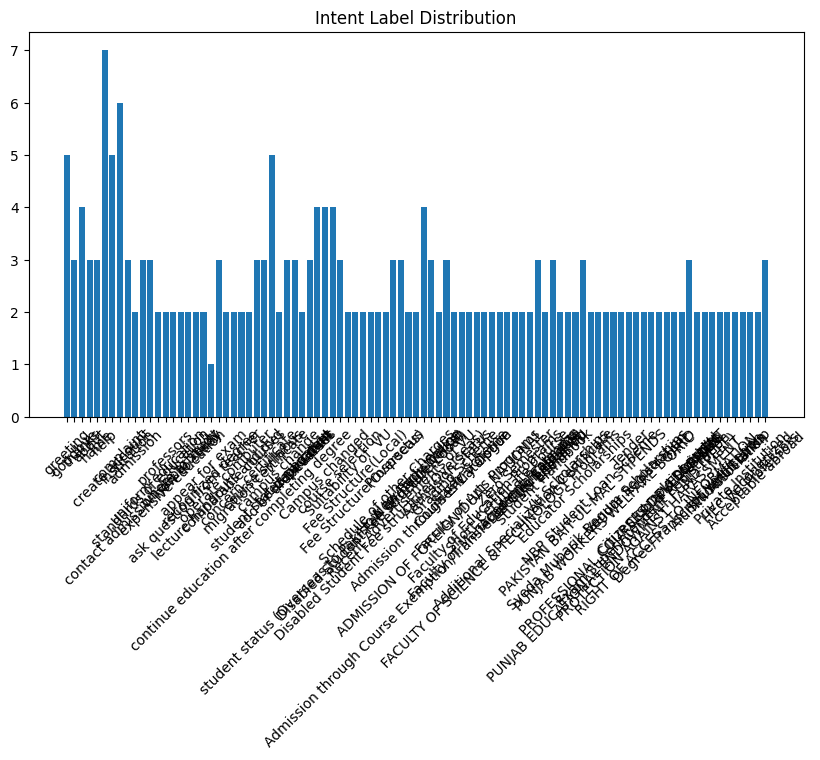

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Print class distribution
label_counts = Counter(labels)
print("Label distribution:", label_counts)

# Plot distribution
plt.figure(figsize=(10,5))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(rotation=45)
plt.title("Intent Label Distribution")
plt.show()

###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.4.1-Check Pefromance Probme-Bert-base-uncased**</p>

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,4.761500,4.502717,0.021277,0.898936,0.021277,0.008511
2,4.761500,4.526128,0.021277,0.920973,0.021277,0.009456
3,4.761500,4.538493,0.000000,0.914894,0.000000,0.000000
4,4.761500,4.573612,0.000000,0.936170,0.000000,0.000000
5,4.571300,4.591160,0.021277,0.943262,0.021277,0.010638


Precision: 0.8989, Recall: 0.0213, F1 Score: 0.0085
Test Accuracy: 0.0213


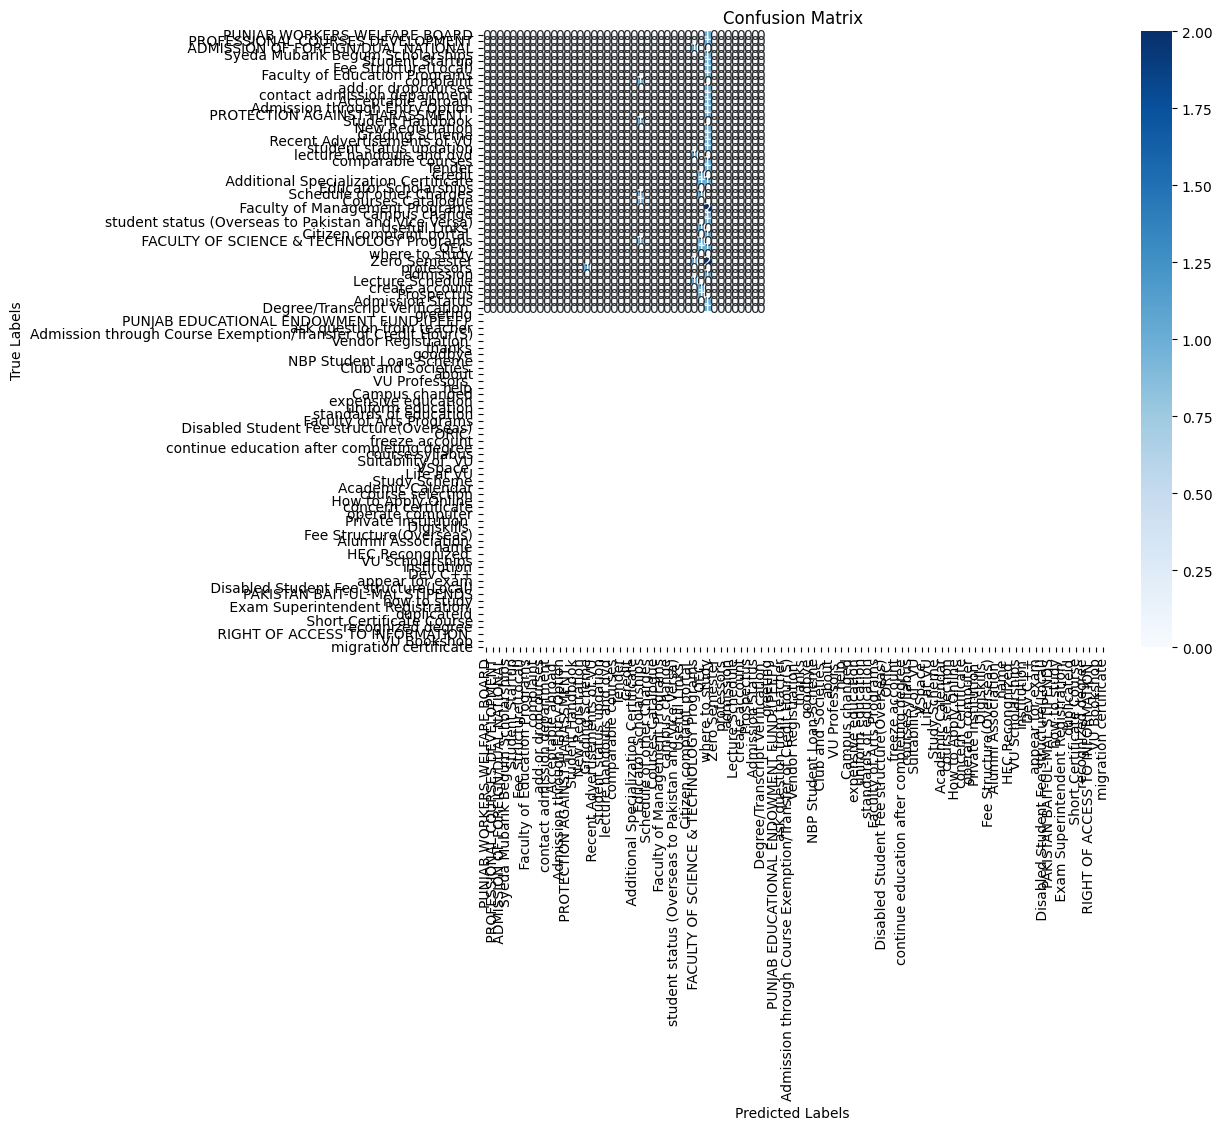

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import IntervalStrategy

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Assuming 'documents' contains text data as (word_list, intent)
train_texts_str = [' '.join(doc[0]) for doc in documents]
labels = [doc[1] for doc in documents]

# Encode labels
all_labels = list(set(labels))
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
y_encoded = label_encoder.transform(labels)

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    train_texts_str, y_encoded, test_size=0.2, shuffle=True, random_state=1)

# Tokenize text
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

num_labels = len(all_labels)

# Calculate class weights
class_counts = [list(labels).count(label) for label in all_labels]
total_samples = len(labels)
class_weights = torch.tensor([total_samples / count for count in class_counts])

# Initialize the model with class weights
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Define a custom loss function that incorporates class weights
def weighted_cross_entropy(logits, labels):
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights, reduction='mean')  # Use reduction='mean' or 'sum'
    loss = loss_fn(logits.view(-1, num_labels), labels.view(-1)) # Reshape logits and labels
    return loss

# Adjusting training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy=IntervalStrategy.EPOCH,
    per_device_train_batch_size=8,  # Adjusted batch size
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    save_strategy=IntervalStrategy.EPOCH,
    learning_rate=3e-5,  # Adjusted learning rate
    logging_steps=100,  # Log every 100 steps
    logging_first_step=True,
    warmup_steps=500,  # Gradual warm-up of learning rate
)

# Compute metrics like F1 score, Precision, Recall
def compute_metrics(p):
    preds = torch.argmax(torch.tensor(p.predictions), axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average="weighted", zero_division=1)
    accuracy = accuracy_score(p.label_ids, preds)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Trainer with updated arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  # Add compute_metrics for evaluation
)

# Train the model, overriding the default loss function
trainer.train()

# Evaluate model on test set
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Compute F1 score, precision, recall
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, preds, average="weighted", zero_division=1)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Print accuracy
accuracy = accuracy_score(test_labels, preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot confusion matrix
cm = confusion_matrix(test_labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5.4.2--Bert-base-uncased**</p>

Model Training without any performance measurement

In [ ]:
import json
import pandas as pd

# Load intents.json
with open('/content/gdrive/MyDrive/Research /Research Projects/Chatbot System in Education /Dataset/intents.json') as f:
    data = json.load(f)

# Convert to DataFrame
dataset = []
for intent in data['intents']:
    for pattern in intent['patterns']:
        dataset.append([pattern, intent['tag']])

df = pd.DataFrame(dataset, columns=['text', 'label'])

# Save as CSV
df.to_csv('intents.csv', index=False)
print("Dataset saved successfully!")


Dataset saved successfully!


In [ ]:
!pip install datasets


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder

# Load dataset
dataset = load_dataset('csv', data_files='intents.csv')

# Extract the training split (since load_dataset returns a DatasetDict with a 'train' key)
dataset = dataset['train']

# Encode labels correctly
label_encoder = LabelEncoder()
label_encoder.fit(dataset['label'])  # Fit the label encoder to all labels
num_labels = len(label_encoder.classes_)  # Get the number of unique labels

# Transform labels within the dataset
dataset = dataset.map(lambda x: {'label': label_encoder.transform([x['label']])[0]},
                      remove_columns=['label'])
# Ensure dataset is a DatasetDict after splitting
dataset = dataset.train_test_split(test_size=0.2)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply tokenization and remove text column
dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Load BERT model
# Use num_labels calculated earlier
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./bert-intent-model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Check dataset keys
print("Dataset keys:", dataset.keys())  # Should print: dict_keys(['train', 'test'])

# Convert labels to floats and rename the column to 'labels'
dataset = dataset.map(lambda examples: {'labels': examples['label']}, batched=True) #The key change

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

# Train model
trainer.train()

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Dataset keys: dict_keys(['train', 'test'])


Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mushtaqmsit (mushtaqmsit-vu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,4.550700,4.737078
2,4.523500,4.698802
3,4.446900,4.677985


TrainOutput(global_step=72, training_loss=4.504510958989461, metrics={'train_runtime': 188.3692, 'train_samples_per_second': 2.994, 'train_steps_per_second': 0.382, 'total_flos': 148515881398272.0, 'train_loss': 4.504510958989461, 'epoch': 3.0})

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder

# Load dataset
dataset = load_dataset('csv', data_files='intents.csv')

# Extract the 'train' dataset (since load_dataset returns a DatasetDict)
dataset = dataset['train']

# Split dataset first to avoid data leakage
dataset = dataset.train_test_split(test_size=0.2)

# Encode labels after splitting
label_encoder = LabelEncoder()
label_encoder.fit(dataset['train']['label'])  # Fit only on training labels
num_labels = len(label_encoder.classes_)  # Get number of unique labels

# Transform labels and ensure they are stored correctly
def encode_labels(example):
    return {'label': label_encoder.transform([example['label']])[0]}  # Ensure correct encoding

dataset = dataset.map(encode_labels, remove_columns=['label'])

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply tokenization and remove text column
dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Convert labels to the correct format for PyTorch
dataset = dataset.map(lambda examples: {'labels': torch.tensor(examples['label'], dtype=torch.long)}, batched=True)

# Load BERT model with correct number of labels
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./bert-intent-model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

# Train model
trainer.train()


ModuleNotFoundError: No module named 'datasets'

##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**DialoGPT (5.5-Microsoft)**</p>

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")

##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**GPT-4 Turbo**</p>

##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Mistral 7B**</p>

##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**LLaMA 3 (Meta)**</p>

##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Claude 3**</p>

##<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**RAG (Retrieval-Augmented Generation)**</p>

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**6- App**</p>

###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**6.1- Improve Version App**</p>

2. Improve NLP Capabilities

Better Tokenization: Instead of nltk.word_tokenize(), use spaCy or transformers from Hugging Face for better text processing.

Use Pretrained Embeddings: Replace your bag-of-words approach with word embeddings (e.g., Word2Vec, FastText, or BERT embeddings) to improve intent classification.

3. Enhance Response Generation

Context Awareness: Your chatbot doesn’t maintain conversation context. You can implement a memory mechanism using session storage or a database (SQLite, Firebase, etc.).

Fallback Responses: If the intent classification confidence is below a threshold, return a "clarification response" instead of a random answer.

4. Improve UI/UX

AJAX-based Chat Interface: Instead of using a GET request (request.args.get('msg')), use WebSockets (Flask-SocketIO) for real-time chat.

Interactive UI: Use Bootstrap, Vue.js, or React.js to enhance the front-end.

In [ ]:
pip install spacy

In [ ]:
pip install gensim


In [ ]:
import nltk
nltk.download('popular')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pickle
import numpy as np

from keras.models import load_model
model = load_model('chat_model') # write your model name
import json
import random
intents = json.loads(open('intents.json').read()) # write your json file name
words = pickle.load(open('texts.pkl','rb')) # tokenizer.pickle
classes = pickle.load(open('labels.pkl','rb')) #lable_encoder.pickle

import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

def clean_up_sentence(sentence):
    doc = nlp(sentence)
    sentence_words = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
    from gensim.models import KeyedVectors

# Load Google's pre-trained Word2Vec model (300-dimensional vectors)
word2vec_model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

def sentence_to_vector(sentence, model, vector_size=300):
    words = clean_up_sentence(sentence)
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

def chatbot_response(msg):
    ints = predict_class(msg, model)
    res = getResponse(ints, intents)
    return res


from flask import Flask, render_template, request, session
from flask_session import Session

app = Flask(__name__)

# Configure session storage
app.config["SESSION_TYPE"] = "filesystem"
Session(app)

# Initialize user session for context tracking
@app.route("/get")
def get_bot_response():
    userText = request.args.get('msg')

    # Retrieve or initialize session context
    if "context" not in session:
        session["context"] = []

    response = chatbot_response(userText)

    # Store conversation history
    session["context"].append({"user": userText, "bot": response})

    return response

###<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**6.2- Orginal App**</p>

In [ ]:
import nltk
nltk.download('popular')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pickle
import numpy as np

from keras.models import load_model
model = load_model('chat_model') # write your model name
import json
import random
intents = json.loads(open('intents.json').read()) # write your json file name
words = pickle.load(open('texts.pkl','rb')) # tokenizer.pickle
classes = pickle.load(open('labels.pkl','rb')) #lable_encoder.pickle

def clean_up_sentence(sentence):
    # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence

def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words)
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s:
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

def chatbot_response(msg):
    ints = predict_class(msg, model)
    res = getResponse(ints, intents)
    return res


from flask import Flask, render_template, request

app = Flask(__name__)
app.static_folder = 'static'

@app.route("/")
def home():
    return render_template("index.html")

@app.route("/get")
def get_bot_response():
    userText = request.args.get('msg')
    return chatbot_response(userText)


if __name__ == "__main__":
    app.run()

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**References**</p>

[1-Chatgpt Roadmap](https://chatgpt.com/c/67dd0d37-384c-800e-8fb3-e12a2efcaab1)

[2-Practical Natural Language Processing](https://github.com/practical-nlp/practical-nlp-code/tree/master)

[3-Intent Classification with Small Transformers](https://github.com/nlptown/nlp-notebooks/blob/master/Intent%20Classification%20with%20Small%20Transformers.ipynb)

[4-Adventures in Zero-Shot Text Classification](https://github.com/nlptown/nlp-notebooks/blob/master/Zero-Shot%20Text%20Classification.ipynb)